In [6]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

#### Ridge regression model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge

print(Path.cwd())

us_per_s = 1000000
bitresolution = 4095
mv_range = 3300

uncovered_df = pd.read_csv("2500_22us_3.csv")[0:-1]
uncovered_df["mv"] = uncovered_df.data * mv_range / bitresolution
uncovered_df["time_s"] = uncovered_df.time_us / us_per_s
print(uncovered_df.head())

covered_df = pd.read_csv("2500_22us_covered0.csv")[0:-1]
covered_df["mv"] = covered_df.data * mv_range / bitresolution
covered_df["time_s"] = covered_df.time_us / us_per_s
print(covered_df.head())


e:\projects\pi-spec-cli
   cnt  time_us  acq_time   data          mv    time_s
0  0.0      0.0      11.0  579.0  466.593407  0.000000
1  1.0     22.0      16.0  577.0  464.981685  0.000022
2  2.0     44.0      11.0  570.0  459.340659  0.000044
3  3.0     66.0      11.0  575.0  463.369963  0.000066
4  4.0     88.0      11.0  574.0  462.564103  0.000088
   cnt  time_us  acq_time   data          mv    time_s
0  0.0      0.0      11.0  346.0  278.827839  0.000000
1  1.0     22.0      11.0  354.0  285.274725  0.000022
2  2.0     44.0      11.0  352.0  283.663004  0.000044
3  3.0     66.0      11.0  346.0  278.827839  0.000066
4  4.0     88.0      11.0  352.0  283.663004  0.000088


In [7]:

def best_fit_line(df_base):
    # pandas to a numpy array
    data = df_base.values

    # reshape, add a dimension so it works in the model
    X, y = data[:, -1].reshape(-1, 1), data[:,-2].reshape(-1, 1)

    # define Ridge regression linear model
    lm = Ridge(alpha=1.0)

    # define model evaluation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    #evaluate model
    scores = np.absolute(cross_val_score(lm, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=1))
    print(f"Mean MAE: {np.mean(scores)} ({np.std(scores)})")

    # fit model
    lm.fit(X, y)

    # predictions
    y_pred = lm.predict(X)
    print(f"coeff: {lm.coef_}, intercept: {lm.intercept_}")

    # add to dataframe
    best_fit = pd.DataFrame({"temp_C":X.flatten(), "best_fit": y_pred.flatten()})


    # join column from best_fit into df
    df = df_base
    df["best_fit"] = best_fit.best_fit
    print(f"df_base + base_fit = {df.shape}\n{df.head()}")

    # create deviation
    # calculate deviation by subtracting the line value from the reading values for ALL data
    df["deviation"] = df.mv - df.best_fit
    #dev_df = create_dev_df(df)
    print(df.head())
    
    return df

dev_cov = best_fit_line(covered_df)
dev_uncov = best_fit_line(uncovered_df)
dev_cov.head()

Mean MAE: 2.560201342223413 (0.08193200930250263)
coeff: [[-0.11994175]], intercept: [282.03040747]
df_base + base_fit = (2500, 7)
   cnt  time_us  acq_time   data          mv    time_s    best_fit
0  0.0      0.0      11.0  346.0  278.827839  0.000000  282.030407
1  1.0     22.0      11.0  354.0  285.274725  0.000022  282.030405
2  2.0     44.0      11.0  352.0  283.663004  0.000044  282.030402
3  3.0     66.0      11.0  346.0  278.827839  0.000066  282.030400
4  4.0     88.0      11.0  352.0  283.663004  0.000088  282.030397
   cnt  time_us  acq_time   data          mv    time_s    best_fit  deviation
0  0.0      0.0      11.0  346.0  278.827839  0.000000  282.030407  -3.202569
1  1.0     22.0      11.0  354.0  285.274725  0.000022  282.030405   3.244320
2  2.0     44.0      11.0  352.0  283.663004  0.000044  282.030402   1.632601
3  3.0     66.0      11.0  346.0  278.827839  0.000066  282.030400  -3.202561
4  4.0     88.0      11.0  352.0  283.663004  0.000088  282.030397   1.632607

,cnt,time_us,acq_time,data,mv,time_s,best_fit,deviation
0,0.0,0.0,11.0,346.0,278.827839,0.000000,282.030407,-3.202569
1,1.0,22.0,11.0,354.0,285.274725,0.000022,282.030405,3.244320
2,2.0,44.0,11.0,352.0,283.663004,0.000044,282.030402,1.632601
3,3.0,66.0,11.0,346.0,278.827839,0.000066,282.030400,-3.202561
4,4.0,88.0,11.0,352.0,283.663004,0.000088,282.030397,1.632607


covered:
deviation stats:
output span: (+8.888355303131107/-12.06171641081437 mV; wrt span of measure)
range: 20.95
span: 3017.9728937728937
*** accuracy = +0.0029451408663977107% and -0.004% of output span
uncovered:
deviation stats:
output span: (+13.212229949121593/-12.581330873945149 mV; wrt span of measure)
range: 25.79
span: 2835.31326007326
*** accuracy = +0.004659883666180932% and -0.004% of output span


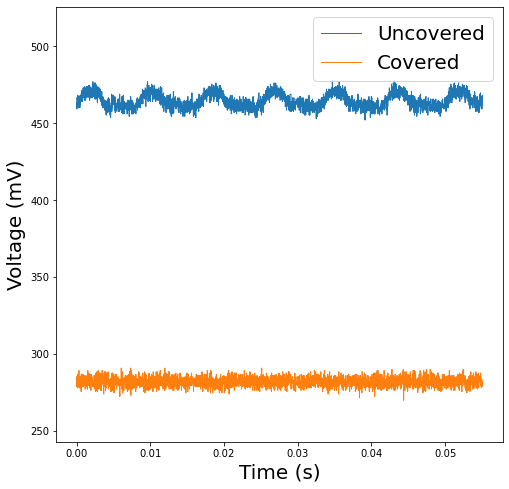

In [16]:
# plot the results
f_size = 20
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), facecolor="white")

# noisy signal from uncovered detector
ax.plot(uncovered_df.time_s, uncovered_df["mv"], linewidth = 1, label='Uncovered')
ax.plot(covered_df.time_s, covered_df["mv"], linewidth = 1, label='Covered')
ax.set_ylabel('Voltage (mV)', size=f_size)
ax.set_xlabel('Time (s)', size=f_size)
ax.set_ylim([min(covered_df.mv * .9), max(uncovered_df.mv * 1.1)])
ax.legend(fontsize=f_size, loc="upper right")
plt.savefig("unc_cov.png")
plt.show()


In [ ]:

def accuracy(df):
   # min/max deviation
    min_dev = min(df["deviation"])
    max_dev = max(df["deviation"])
    
    range = round(max_dev - min_dev, 2)
    span =  mv_range - np.mean(df["mv"])
    plus_acc = (max_dev / span)
    min_acc = round(min_dev / span, 3)
    print("deviation stats:")

    # accuracy limit
    print(f"output span: (+{max_dev}/{min_dev} mV; wrt span of measure)")
    print(f"range: {range}")
    print(f"span: {span}")
    print(f"*** accuracy = +{plus_acc}% and {min_acc}% of output span")

print("covered:")
accuracy(dev_cov)

print("uncovered:")
accuracy(dev_uncov)


# plot calibration and deviation plots in one figure
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), facecolor="white")
fig_letter_x, fig_letter_y = (13, .85)

# plot calibration curve with best fit line
ax[0].scatter(dev_df.temp_C, dev_df.reading, marker='8', color='red', facecolors='none')
ax[0].set_ylabel('Camera reading (°C)', size=16)
ax[0].set_xlabel('True temperature (°C)', size=16)
ax[0].plot(dev_df.temp_C, dev_df.best_fit, color = "black")
ax[0].annotate(text=(f"best-fit line:\ncoeff: {round(float(lm.coef_),2)}, \nintercept: {round(float(lm.intercept_),2)}"), xy=(32,17), size=12)
ax[0].annotate(text=("a"), xy=(15,38), size=20, weight="bold")
# ax[1].text(fig_letter_x, fig_letter_y, "b", size=20, weight="bold", color="black")

# and now for the deviation plot
# ax[1].set_ylim(-1, 1)   
# ax[1].scatter(dev_df["temp_C"], dev_df["avg_up"], color= "orange", facecolors='none', label="mean up", marker='s')
# ax[1].scatter(dev_df["temp_C"], dev_df["avg_updown"], color = 'black', label="mean up/down")
# ax[1].scatter(dev_df["temp_C"], dev_df["avg_down"], color= "blue", facecolors='none', label="mean down", marker='s')
ax[1].scatter(dev_df["temp_C"], dev_df["deviation"], color= "red", facecolors='none', label="deviation", marker='s')
ax[1].plot([14,41], [0,0], color="black", linewidth=0.75)
# ax[1].plot(nonlin_x, nonlin_y, color="black", linewidth=2, label="non-linearity")
ax[1].plot([14,41], [min_dev,min_dev], '-.', color="black", linewidth=0.5, label="accuracy limits")
ax[1].plot([14,41], [max_dev,max_dev], '-.', color="black", linewidth=0.5)

ax[1].set_ylabel('Deviation (°C)', size=16)
ax[1].set_xlabel('True temperature (°C)', size=16)
ax[1].legend(bbox_to_anchor=(1, .9), loc='upper right', ncol=1)
ax[1].text(fig_letter_x, fig_letter_y, "", size=20, weight="bold", color="black")




fig.tight_layout(pad=3.0)
    
plt.show()